In [211]:
"""
Taken from Original Notebook With Correct bt3 Strategy Implementation
(After Data Comparison Analysis)

instead of using XL data, use yf API downloaded data

Target Implementations:
End of month data
Correct index and date format
flag = np.select([SPY_TLT_som < 0], [1], [-1])
Correct Shift
Backtest for strategy 1 and 3
""";

In [212]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
from scipy.stats import linregress

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import datetime as dt
import time

In [213]:
# Read a CSV file containing daily stock prices for SPY (S&P 500) and TLT (Treasury bonds)
import os

# Corrected path - remove the duplicate 09_projects and use correct filename
path = os.path.abspath(os.path.join("..", "01_The Unintended Consequences of Rebalancing", "data_SPY_TLT_2002-07-30_D.csv"))

# Check if file exists before reading
if not os.path.exists(path):
    print(f"File not found")
    print("Current working directory:", os.getcwd())
    print("Available files in current directory:")
    current_dir = os.path.dirname(path)
    if os.path.exists(current_dir):
        for item in os.listdir(current_dir):
            if item.endswith('.csv'):
                print(f"  - {item}")
    else:
        print("Directory doesn't exist")
        # Try alternative paths
        alternative_paths = [
            "data_SPY_TLT_2002-07-30_D.csv",
            os.path.join(".", "data_SPY_TLT_2002-07-30_D.csv"),
            os.path.abspath("data_SPY_TLT_2002-07-30_D.csv")
        ]
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                print(f"Found file at alternative path: {alt_path}")
                path = alt_path
                break
else:
    print(f"File found")

# Read the CSV file
if os.path.exists(path):
    df = pd.read_csv(path)
    print("DataFrame loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
else:
    print("Could not locate the CSV file. Please check the file location.")

File found
DataFrame loaded successfully!
Shape: (11700, 3)

First 5 rows:
         Date Ticker      Close
0  2002-07-30    SPY  59.177753
1  2002-07-30    TLT  37.055656
2  2002-07-31    SPY  59.320934
3  2002-07-31    TLT  37.514767
4  2002-08-01    SPY  57.772179


In [214]:
# N = 15: The first 15 trading days of each month = "Start of Month" (SOM)
# M = 5: The first 5 trading days of each month = "Next Start of Month" (NSM)
# Everything after day 15 = "End of Month" (EOM)
N = 15
M = 5

In [215]:
# Convert the date column so the computer can understand dates properly

# pivot the dataframe to have tickers as columns
df = df.pivot(index='Date', columns='Ticker', values='Close')
df.index = pd.to_datetime(df.index) 
df = df.sort_index()
df = df.ffill().dropna()
df.tail()

Ticker,SPY,TLT
Date,,
2025-10-21,671.289978,92.000000
2025-10-22,667.799988,92.059998
2025-10-23,671.760010,91.430000
2025-10-24,677.250000,91.470001
2025-10-27,685.239990,91.779999


In [216]:
# rename columns to spy_pct_change and tlt_pct_change
df = df.rename(columns={'SPY': 'spy_pct_change', 'TLT': 'tlt_pct_change'})

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5850 entries, 2002-07-30 to 2025-10-27
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   spy_pct_change  5850 non-null   float64
 1   tlt_pct_change  5850 non-null   float64
dtypes: float64(2)
memory usage: 137.1 KB


In [218]:
# calculate daily returns
df = df.pct_change().dropna()

# fill na values with 0
df = df.fillna(0)

# add cumsum_simple for each ticker (cumsum_simple)
df['spy_cumsum_simple'] = df['spy_pct_change'].cumsum()
df['tlt_cumsum_simple'] = df['tlt_pct_change'].cumsum()

df.tail()

Ticker,spy_pct_change,tlt_pct_change,spy_cumsum_simple,tlt_cumsum_simple
Date,,,,
2025-10-21,-0.000015,0.004915,2.846328,1.150526
2025-10-22,-0.005199,0.000652,2.841129,1.151178
2025-10-23,0.005930,-0.006843,2.847059,1.144334
2025-10-24,0.008173,0.000438,2.855232,1.144772
2025-10-27,0.011798,0.003389,2.867029,1.148161


In [219]:
# add year, month, day columns
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

# drop first row since there is only one business days for the month of July 2002
df = df.iloc[1:]

In [220]:
# add difference column between SPY and TLT
df['pct_change_diff'] = df['spy_pct_change'] - df['tlt_pct_change']

In [221]:
df.head()


Ticker,spy_pct_change,tlt_pct_change,spy_cumsum_simple,tlt_cumsum_simple,year,month,day,pct_change_diff
Date,,,,,,,,
2002-08-01,-0.026108,0.005695,-0.023689,0.018085,2002,8,1,-0.031803
2002-08-02,-0.022415,0.010241,-0.046104,0.028326,2002,8,2,-0.032657
2002-08-05,-0.034797,0.004412,-0.080901,0.032739,2002,8,5,-0.039209
2002-08-06,0.033664,-0.008548,-0.047237,0.024190,2002,8,6,0.042213
2002-08-07,0.017438,0.002395,-0.029798,0.026585,2002,8,7,0.015044


In [222]:
def create_monthly_periods(df):
    """
    Split each month into periods and calculate cumulative returns:
    - Period 1: First 15 business days of the month
    - Period 2: Remaining business days of the month (N-15 days)
    - Period 3: First 5 business days of the next month
    """
    
    results = []
    
    # Group by year and month
    monthly_groups = df.groupby(['year', 'month'])
    
    for (year, month), group in monthly_groups:
        # Sort by date to ensure proper order
        group = group.sort_index()
        
        # Get the number of trading days in this month
        n_days = len(group)
        
        # Period 1: First 15 days (or all days if less than 15)
        period1_end = min(15, n_days)
        period1_data = group.iloc[:period1_end]
        
        # Period 2: Remaining days (if more than 15 days in month)
        if n_days > 15:
            period2_data = group.iloc[15:]
        else:
            period2_data = pd.DataFrame()  # Empty if month has ≤15 days
        
        # Period 3: First 5 days of next month
        next_month = month + 1 if month < 12 else 1
        next_year = year if month < 12 else year + 1
        
        try:
            next_month_group = monthly_groups.get_group((next_year, next_month))
            next_month_group = next_month_group.sort_index()
            period3_data = next_month_group.iloc[:5]  # First 5 days
        except KeyError:
            # Next month doesn't exist in data
            period3_data = pd.DataFrame()
        
        # Calculate cumulative returns for each period
        def calc_period_stats(period_data, period_name):
            if len(period_data) == 0:
                return None
            
            spy_cumsum = period_data['spy_pct_change'].cumsum()
            tlt_cumsum = period_data['tlt_pct_change'].cumsum()
            diff_cumsum = period_data['pct_change_diff'].cumsum()
            
            return {
                'year': year,
                'month': month,
                'period': period_name,
                'start_date': period_data.index[0],
                'end_date': period_data.index[-1],
                'trading_days': len(period_data),
                'spy_cumsum_final': spy_cumsum.iloc[-1],
                'tlt_cumsum_final': tlt_cumsum.iloc[-1],
                'diff_cumsum_final': diff_cumsum.iloc[-1],
                # 'spy_cumsum_series': spy_cumsum,
                # 'tlt_cumsum_series': tlt_cumsum,
                # 'diff_cumsum_series': diff_cumsum
            }
        
        # Calculate stats for each period
        period1_stats = calc_period_stats(period1_data, 'first_15_days')
        period2_stats = calc_period_stats(period2_data, 'remaining_days')
        period3_stats = calc_period_stats(period3_data, 'next_month_first_5')
        
        # Add to results (only non-None periods)
        for stats in [period1_stats, period2_stats, period3_stats]:
            if stats is not None:
                results.append(stats)
    
    return pd.DataFrame(results)

# Execute the function
monthly_periods = create_monthly_periods(df)

# Display summary
print("Monthly Period Analysis Summary")
print("=" * 50)
print(f"Total periods analyzed: {len(monthly_periods)}")
print(f"Period types: {monthly_periods['period'].value_counts()}")
print("\nFirst few periods:")
print(monthly_periods[['year', 'month', 'period', 'trading_days', 
                      'spy_cumsum_final', 'tlt_cumsum_final', 'diff_cumsum_final']].head(10))

Monthly Period Analysis Summary
Total periods analyzed: 836
Period types: period
first_15_days         279
remaining_days        279
next_month_first_5    278
Name: count, dtype: int64

First few periods:
   year  month              period  trading_days  spy_cumsum_final  \
0  2002      8       first_15_days            15          0.052944   
1  2002      8      remaining_days             7         -0.041722   
2  2002      8  next_month_first_5             5         -0.011275   
3  2002      9       first_15_days            15         -0.086202   
4  2002      9      remaining_days             5         -0.021354   
5  2002      9  next_month_first_5             5         -0.031047   
6  2002     10       first_15_days            15          0.103316   
7  2002     10      remaining_days             8         -0.017800   
8  2002     10  next_month_first_5             5          0.025648   
9  2002     11       first_15_days            15          0.062579   

   tlt_cumsum_final  dif

In [223]:
monthly_periods.head(20)

,year,month,period,start_date,end_date,trading_days,spy_cumsum_final,tlt_cumsum_final,diff_cumsum_final
0,2002,8,first_15_days,2002-08-01,2002-08-21,15,0.052944,0.039473,0.013471
1,2002,8,remaining_days,2002-08-22,2002-08-30,7,-0.041722,0.014861,-0.056583
2,2002,8,next_month_first_5,2002-09-03,2002-09-09,5,-0.011275,0.007363,-0.018638
3,2002,9,first_15_days,2002-09-03,2002-09-23,15,-0.086202,0.038762,-0.124965
4,2002,9,remaining_days,2002-09-24,2002-09-30,5,-0.021354,0.003459,-0.024813
5,2002,9,next_month_first_5,2002-10-01,2002-10-07,5,-0.031047,-0.004316,-0.026731
6,2002,10,first_15_days,2002-10-01,2002-10-21,15,0.103316,-0.062589,0.165905
7,2002,10,remaining_days,2002-10-22,2002-10-31,8,-0.017800,0.025719,-0.043520
8,2002,10,next_month_first_5,2002-11-01,2002-11-07,5,0.025648,0.016295,0.009353
9,2002,11,first_15_days,2002-11-01,2002-11-21,15,0.062579,-0.001822,0.064401


In [224]:
"""
monthly_periods.head(20)

year	month	period	start_date	end_date	trading_days	spy_cumsum_final	tlt_cumsum_final	diff_cumsum_final
0	2002	8	first_15_days	2002-08-01	2002-08-21	15	0.052944	0.039473	0.013471
1	2002	8	remaining_days	2002-08-22	2002-08-30	7	-0.041722	0.014861	-0.056583
2	2002	8	next_month_first_5	2002-09-03	2002-09-09	5	-0.011275	0.007363	-0.018638
3	2002	9	first_15_days	2002-09-03	2002-09-23	15	-0.086202	0.038762	-0.124965
4	2002	9	remaining_days	2002-09-24	2002-09-30	5	-0.021354	0.003459	-0.024813
5	2002	9	next_month_first_5	2002-10-01	2002-10-07	5	-0.031047	-0.004316	-0.026731
6	2002	10	first_15_days	2002-10-01	2002-10-21	15	0.103316	-0.062589	0.165905
7	2002	10	remaining_days	2002-10-22	2002-10-31	8	-0.017800	0.025719	-0.043520
8	2002	10	next_month_first_5	2002-11-01	2002-11-07	5	0.025648	0.016295	0.009353
9	2002	11	first_15_days	2002-11-01	2002-11-21	15	0.062579	-0.001822	0.064401
10	2002	11	remaining_days	2002-11-22	2002-11-29	5	-0.000567	-0.006282	0.005715
11	2002	11	next_month_first_5	2002-12-02	2002-12-06	5	-0.020783	0.011797	-0.032580
12	2002	12	first_15_days	2002-12-02	2002-12-20	15	-0.037136	0.025930	-0.063066
13	2002	12	remaining_days	2002-12-23	2002-12-31	6	-0.019431	0.018621	-0.038052
14	2002	12	next_month_first_5	2003-01-02	2003-01-08	5	0.035963	-0.017636	0.053599
15	2003	1	first_15_days	2003-01-02	2003-01-23	15	0.006712	-0.012098	0.018809
16	2003	1	remaining_days	2003-01-24	2003-01-31	6	-0.029358	0.007022	-0.036380
17	2003	1	next_month_first_5	2003-02-03	2003-02-07	5	-0.031000	0.007667	-0.038667
18	2003	2	first_15_days	2003-02-03	2003-02-24	15	-0.025638	0.011195	-0.036833
19	2003	2	remaining_days	2003-02-25	2003-02-28	4	0.013288	0.019588	-0.006300


""";

In [225]:
# print values of monthly_periods.period where period is 'next_month_first_5'
next_month_first_5_check = monthly_periods[monthly_periods['period'] == 'next_month_first_5'].head(10)
next_month_first_5_check

,year,month,period,start_date,end_date,trading_days,spy_cumsum_final,tlt_cumsum_final,diff_cumsum_final
2,2002,8,next_month_first_5,2002-09-03,2002-09-09,5,-0.011275,0.007363,-0.018638
5,2002,9,next_month_first_5,2002-10-01,2002-10-07,5,-0.031047,-0.004316,-0.026731
8,2002,10,next_month_first_5,2002-11-01,2002-11-07,5,0.025648,0.016295,0.009353
11,2002,11,next_month_first_5,2002-12-02,2002-12-06,5,-0.020783,0.011797,-0.032580
14,2002,12,next_month_first_5,2003-01-02,2003-01-08,5,0.035963,-0.017636,0.053599
17,2003,1,next_month_first_5,2003-02-03,2003-02-07,5,-0.031000,0.007667,-0.038667
20,2003,2,next_month_first_5,2003-03-03,2003-03-07,5,-0.018517,0.004780,-0.023297
23,2003,3,next_month_first_5,2003-04-01,2003-04-07,5,0.038752,-0.019003,0.057755
26,2003,4,next_month_first_5,2003-05-01,2003-05-07,5,0.016137,0.014551,0.001586
29,2003,5,next_month_first_5,2003-06-02,2003-06-06,5,0.023687,-0.000558,0.024245


In [226]:
# data crosscheck
# from monthly_periods, keep only period = first_15_days and calculate the sum diff_cumsum_final
first_15_days = monthly_periods[monthly_periods['period'] == 'first_15_days']
period_performance = first_15_days[['year', 'month', 'diff_cumsum_final']].copy()
period_performance['sum_diff_cumsum_final'] = period_performance['diff_cumsum_final'].cumsum()
period_performance.tail(5)

,year,month,diff_cumsum_final,sum_diff_cumsum_final
822,2025,6,0.011458,2.111759
825,2025,7,0.033540,2.145299
828,2025,8,0.007688,2.152987
831,2025,9,0.007958,2.160945
834,2025,10,-0.024447,2.136498


In [227]:
"""
first_15_days df is obtained from monthly_periods, filtering period = 'first_15_days'
remaining_days df is obtained from monthly_periods, filtering period = 'remaining_days'
next_month_first_5 df is obtained from monthly_periods, filtering period = 'next_month_first_5'
""";

first_15_days = monthly_periods[monthly_periods['period'] == 'first_15_days']
remaining_days = monthly_periods[monthly_periods['period'] == 'remaining_days']
next_month_first_5 = monthly_periods[monthly_periods['period'] == 'next_month_first_5']

# print head of each df, to check data
print("First 15 Days Periods:")
print(first_15_days.head())
print("\nRemaining Days Periods:")
print(remaining_days.head())
print("\nNext Month First 5 Days Periods:")
print(next_month_first_5.head())

First 15 Days Periods:
    year  month         period start_date   end_date  trading_days  \
0   2002      8  first_15_days 2002-08-01 2002-08-21            15   
3   2002      9  first_15_days 2002-09-03 2002-09-23            15   
6   2002     10  first_15_days 2002-10-01 2002-10-21            15   
9   2002     11  first_15_days 2002-11-01 2002-11-21            15   
12  2002     12  first_15_days 2002-12-02 2002-12-20            15   

    spy_cumsum_final  tlt_cumsum_final  diff_cumsum_final  
0           0.052944          0.039473           0.013471  
3          -0.086202          0.038762          -0.124965  
6           0.103316         -0.062589           0.165905  
9           0.062579         -0.001822           0.064401  
12         -0.037136          0.025930          -0.063066  

Remaining Days Periods:
    year  month          period start_date   end_date  trading_days  \
1   2002      8  remaining_days 2002-08-22 2002-08-30             7   
4   2002      9  remaining_da

In [228]:
# Compare data (diff_cumsum_final) from the three periods with the excel sheet provided
# sum of diff_cumsum_final from the three periods should match the excel sheet values
first_15_days_sum = first_15_days['diff_cumsum_final'].sum()
remaining_days_sum = remaining_days['diff_cumsum_final'].sum()
next_month_first_5_sum = next_month_first_5['diff_cumsum_final'].sum()

# print the values
print(f"\nSum of diff_cumsum_final for First 15 Days: {first_15_days_sum:.6f}")
print(f"Sum of diff_cumsum_final for Remaining Days: {remaining_days_sum:.6f}")
print(f"Sum of diff_cumsum_final for Next Month First 5 Days: {next_month_first_5_sum:.6f}")


Sum of diff_cumsum_final for First 15 Days: 2.136498
Sum of diff_cumsum_final for Remaining Days: -0.407660
Sum of diff_cumsum_final for Next Month First 5 Days: 1.665663


In [229]:
# analyze diff_cumsum_final using describe() method
print("\nDescriptive Statistics for diff_cumsum_final in First 15 Days:")
print(first_15_days['diff_cumsum_final'].describe())
print("\nDescriptive Statistics for diff_cumsum_final in Remaining Days:")
print(remaining_days['diff_cumsum_final'].describe())
print("\nDescriptive Statistics for diff_cumsum_final in Next Month First 5 Days:")
print(next_month_first_5['diff_cumsum_final'].describe())


Descriptive Statistics for diff_cumsum_final in First 15 Days:
count    279.000000
mean       0.007658
std        0.062860
min       -0.291706
25%       -0.020712
50%        0.014544
75%        0.043157
max        0.165905
Name: diff_cumsum_final, dtype: float64

Descriptive Statistics for diff_cumsum_final in Remaining Days:
count    279.000000
mean      -0.001461
std        0.031102
min       -0.119362
25%       -0.018804
50%       -0.000867
75%        0.016784
max        0.120153
Name: diff_cumsum_final, dtype: float64

Descriptive Statistics for diff_cumsum_final in Next Month First 5 Days:
count    278.000000
mean       0.005992
std        0.038499
min       -0.189462
25%       -0.013336
50%        0.010455
75%        0.030456
max        0.093900
Name: diff_cumsum_final, dtype: float64


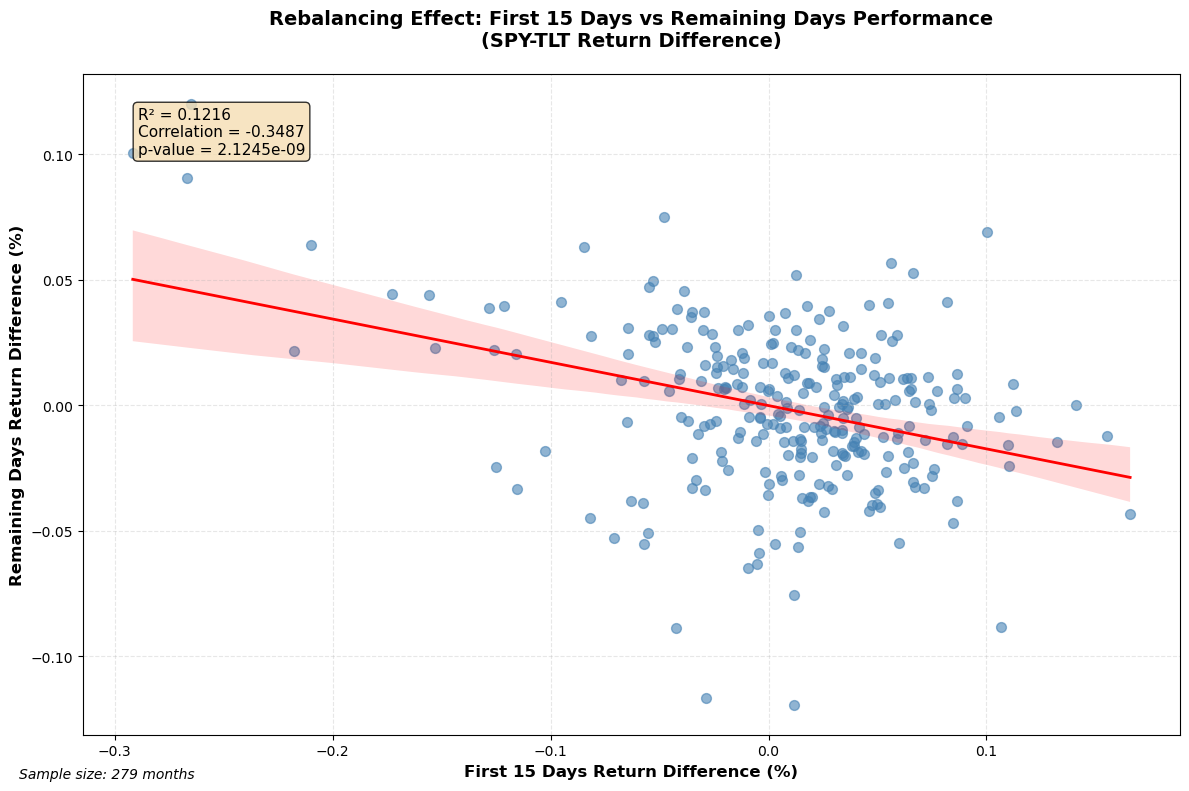


REBALANCING CORRELATION ANALYSIS
Sample size: 279 months
Correlation coefficient: -0.3487
R-squared: 0.1216
P-value: 2.1245e-09
Statistical significance: Yes (α = 0.05)

Interpretation:
• Moderate negative correlation between early and late month performance
• 12.2% of variance in remaining days explained by first 15 days


In [230]:
# Scatter plot: First 15 Days vs Remaining Days Performance
plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=first_15_days['diff_cumsum_final'], 
    y=remaining_days['diff_cumsum_final'],
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
x_data = first_15_days['diff_cumsum_final']
y_data = remaining_days['diff_cumsum_final']
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Rebalancing Effect: First 15 Days vs Remaining Days Performance\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('First 15 Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Remaining Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between early and late month performance")
print(f"• {r_squared*100:.1f}% of variance in remaining days explained by first 15 days")
print("="*60)

In [231]:
import statsmodels.formula.api as smf

# Reset indices and align the data properly
first_15_data = first_15_days.reset_index()
remaining_data = remaining_days.reset_index()

# Method 1: Merge based on year and month
regression_data = pd.merge(
    first_15_data[['year', 'month', 'diff_cumsum_final']],
    remaining_data[['year', 'month', 'diff_cumsum_final']],
    on=['year', 'month'],
    suffixes=('_som', '_eom')
)

# Rename columns for clarity
regression_data = regression_data.rename(columns={
    'diff_cumsum_final_som': 'SPY_TLT_som',
    'diff_cumsum_final_eom': 'SPY_TLT_eom'
})

# Remove any rows with NaN values
regression_data = regression_data.dropna()

print(f"Regression data shape: {regression_data.shape}")
print("First few rows:")
print(regression_data.head())

# Now run the regression
if len(regression_data) > 0:
    mod = smf.ols('SPY_TLT_eom ~ SPY_TLT_som', data=regression_data)
    res = mod.fit()
    print(res.summary())
else:
    print("No data available for regression after alignment.")

Regression data shape: (279, 4)
First few rows:
   year  month  SPY_TLT_som  SPY_TLT_eom
0  2002      8     0.013471    -0.056583
1  2002      9    -0.124965    -0.024813
2  2002     10     0.165905    -0.043520
3  2002     11     0.064401     0.005715
4  2002     12    -0.063066    -0.038052
                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_eom   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     38.35
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           2.12e-09
Time:                        23:50:07   Log-Likelihood:                 590.97
No. Observations:                 279   AIC:                            -1178.
Df Residuals:                     277   BIC:                            -1171.
Df Model:                           1                                     

Return data prepared for backtesting:
Data shape: (279, 4)
Date range: 2002-08-31 00:00:00 to 2025-10-31 00:00:00

First 5 rows:
            SPY_TLT_som  SPY_TLT_eom  SPY_TLT_nsm   SPY_ret
ym                                                         
2002-08-31     0.013471    -0.056583    -0.018638 -0.043113
2002-09-30    -0.124965    -0.024813    -0.026731 -0.149778
2002-10-31     0.165905    -0.043520     0.009353  0.122385
2002-11-30     0.064401     0.005715    -0.032580  0.070117
2002-12-31    -0.063066    -0.038052     0.053599 -0.101118

Backtest completed. Strategy performance data:
Data points: 279

Last 5 performance values:
            ym  SPY_TLT_nsm_pl   cpl_nsm  SPY_benchmark
274 2025-06-30        0.025751  1.290317       3.214321
275 2025-07-31       -0.011972  1.274869       3.323219
276 2025-08-31       -0.033804  1.231773       3.391050
277 2025-09-30        0.003019  1.235492       3.389119
278 2025-10-31        0.000000  1.235492       3.384440

CROSS-MONTH STRATEGY 

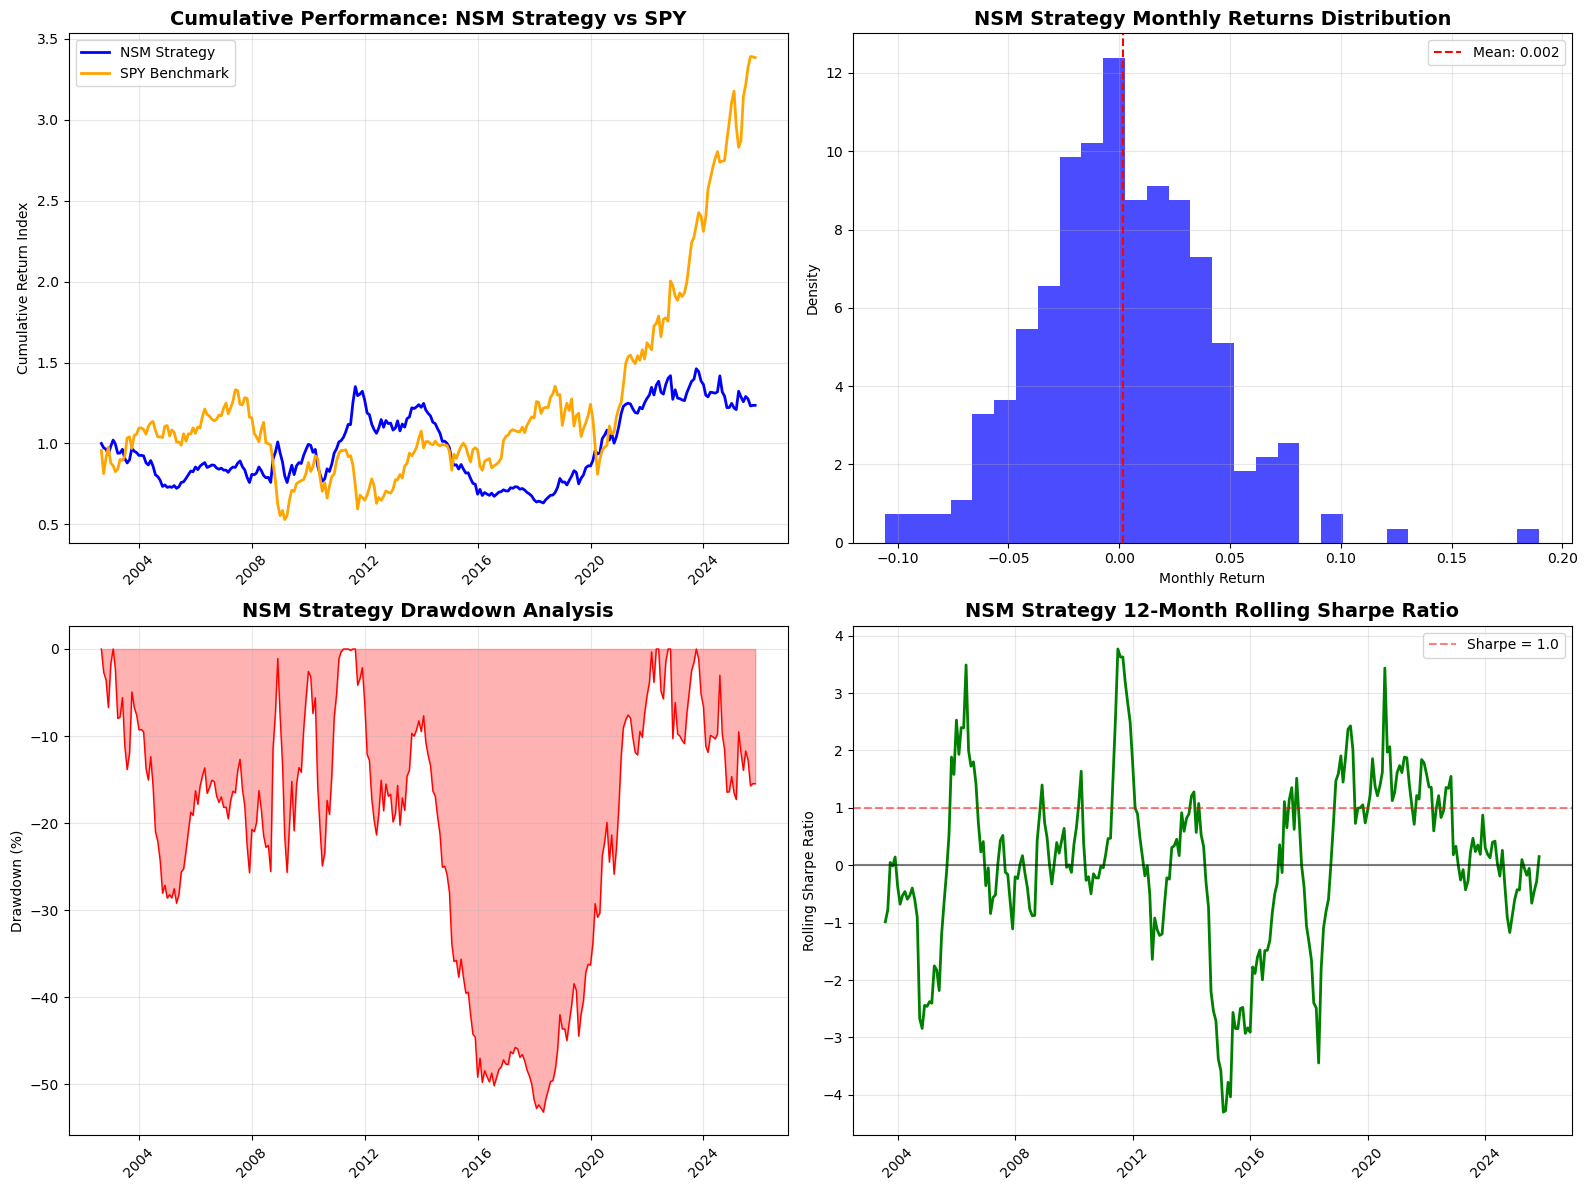


SIGNAL ANALYSIS
Signal Distribution:
  Long NSM: 176 months (63.1%)
  Short NSM: 103 months (36.9%)

Success Rate by Signal:
           Total_Trades  Successful_Trades  Success_Rate
signal                                                  
Long NSM            176                105      0.596591
Short NSM           103                 33      0.320388

Average Return by Signal:
           Mean_Return  Std_Return
signal                            
Long NSM      0.005977    0.035698
Short NSM    -0.006140    0.042819

STRATEGY SUMMARY
The Cross-Month Strategy Implementation (NSM) captures mean reversion effects
by using the previous month's signal (inverted) to trade the first 5 days
of the following month. This exploits institutional rebalancing patterns
where initial outperformance tends to reverse in subsequent periods.


In [ ]:
## wrong, to check

# from scipy.stats import pearsonr

# # First, we need to prepare the data in the correct format for backtesting
# # Convert the monthly periods data to the format expected by the strategy

# # Create the return_data DataFrame from your monthly_periods data
# def prepare_return_data_for_backtest_corrected(monthly_periods):
#     """
#     Convert monthly_periods data to the format expected by the strategy
#     WITH CORRECT SPY_ret calculation
#     """
#     # Create separate DataFrames for each period type
#     som_data = monthly_periods[monthly_periods['period'] == 'first_15_days'][['year', 'month', 'spy_cumsum_final', 'tlt_cumsum_final', 'diff_cumsum_final']].copy()
#     eom_data = monthly_periods[monthly_periods['period'] == 'remaining_days'][['year', 'month', 'spy_cumsum_final', 'tlt_cumsum_final', 'diff_cumsum_final']].copy()
#     nsm_data = monthly_periods[monthly_periods['period'] == 'next_month_first_5'][['year', 'month', 'spy_cumsum_final', 'tlt_cumsum_final', 'diff_cumsum_final']].copy()
    
#     # Create year-month date for proper indexing
#     som_data['ym'] = pd.to_datetime(som_data[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)
#     eom_data['ym'] = pd.to_datetime(eom_data[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)
#     nsm_data['ym'] = pd.to_datetime(nsm_data[['year', 'month']].assign(day=1)) + pd.offsets.MonthEnd(0)
    
#     # Rename columns to match strategy expectations
#     som_data = som_data.rename(columns={
#         'diff_cumsum_final': 'SPY_TLT_som',
#         'spy_cumsum_final': 'SPY_som',
#         'tlt_cumsum_final': 'TLT_som'
#     })
#     eom_data = eom_data.rename(columns={
#         'diff_cumsum_final': 'SPY_TLT_eom', 
#         'spy_cumsum_final': 'SPY_eom',
#         'tlt_cumsum_final': 'TLT_eom'
#     })
#     nsm_data = nsm_data.rename(columns={
#         'diff_cumsum_final': 'SPY_TLT_nsm',
#         'spy_cumsum_final': 'SPY_nsm', 
#         'tlt_cumsum_final': 'TLT_nsm'
#     })
    
#     # Merge all data together
#     return_data = som_data[['ym', 'SPY_TLT_som', 'SPY_som', 'TLT_som']].merge(
#         eom_data[['ym', 'SPY_TLT_eom', 'SPY_eom', 'TLT_eom']], on='ym', how='outer'
#     ).merge(
#         nsm_data[['ym', 'SPY_TLT_nsm', 'SPY_nsm', 'TLT_nsm']], on='ym', how='outer'
#     ).set_index('ym').sort_index()
    
#     # Fill missing values
#     return_data = return_data.fillna(0)
    
#     # CORRECT SPY_ret calculation: Sum of actual SPY returns for the full month
#     return_data['SPY_ret'] = return_data['SPY_som'] + return_data['SPY_eom']
#     return_data['TLT_ret'] = return_data['TLT_som'] + return_data['TLT_eom']
    
#     return return_data

# # Prepare the data
# return_data = prepare_return_data_for_backtest(monthly_periods)

# print("Return data prepared for backtesting:")
# print(f"Data shape: {return_data.shape}")
# print(f"Date range: {return_data.index.min()} to {return_data.index.max()}")
# print("\nFirst 5 rows:")
# print(return_data.head())

# # Implement the Cross-Month Strategy (NSM Strategy)
# def backtest_cross_month_strategy(return_data):
#     """
#     Backtest the Cross-Month Strategy Implementation (SPY_TLT_nsm_pl)
    
#     This strategy:
#     1. Generates signals based on previous month's SOM performance
#     2. Trades the NSM (Next Start of Month) period with inverted signal
#     3. Captures mean reversion effects from institutional rebalancing
#     """
    
#     pl_data = (
#         return_data
#         .assign(
#             # Signal Generation: Flag based on SOM relative performance
#             flag=lambda x: np.select([x['SPY_TLT_som'] < 0], [1], -1),
            
#             # End-of-Month P&L (for reference, not used in NSM strategy)
#             SPY_TLT_eom_pl=lambda x: x['flag'] * x['SPY_TLT_eom'],
            
#             # CORE NSM STRATEGY: Cross-Month Implementation
#             # Uses previous month's signal (shifted) with inversion (-) for mean reversion
#             SPY_TLT_nsm_pl=lambda x: (-x['flag'].shift(1) * x['SPY_TLT_nsm']).fillna(0.0),
            
#             # Combined strategy (EOM + NSM) for comparison
#             pl_combined=lambda x: x['SPY_TLT_eom_pl'] + x['SPY_TLT_nsm_pl'],
            
#             # Cumulative Performance Tracking
#             cpl_nsm=lambda x: (1 + x['SPY_TLT_nsm_pl']).cumprod(),          # NSM Strategy only
#             cpl_combined=lambda x: (1 + x['pl_combined']).cumprod(),        # Combined Strategy
#             SPY_benchmark=lambda x: (1 + x['SPY_ret']).cumprod()            # SPY Benchmark
#         )
#         .reset_index()
#     )
    
#     return pl_data

# # Execute the backtest
# pl_data = backtest_cross_month_strategy(return_data)

# print("\nBacktest completed. Strategy performance data:")
# print(f"Data points: {len(pl_data)}")
# print("\nLast 5 performance values:")
# print(pl_data[['ym', 'SPY_TLT_nsm_pl', 'cpl_nsm', 'SPY_benchmark']].tail())

# # Performance Analytics
# def calculate_strategy_metrics(pl_data):
#     """
#     Calculate comprehensive performance metrics for the NSM strategy
#     """
#     # NSM Strategy Metrics
#     returns_nsm = pl_data['SPY_TLT_nsm_pl'].dropna()
    
#     ret_nsm_annual = returns_nsm.mean() * 12
#     vol_nsm_annual = returns_nsm.std() * np.sqrt(12)
#     sharpe_nsm = ret_nsm_annual / vol_nsm_annual if vol_nsm_annual > 0 else 0
    
#     # Maximum Drawdown for NSM
#     cumulative_nsm = pl_data['cpl_nsm'].dropna()
#     running_max_nsm = cumulative_nsm.expanding().max()
#     drawdown_nsm = (cumulative_nsm / running_max_nsm - 1.0)
#     max_dd_nsm = drawdown_nsm.min()
    
#     # Benchmark (SPY) Metrics
#     returns_spy = pl_data['SPY_ret'].dropna()
    
#     ret_spy_annual = returns_spy.mean() * 12
#     vol_spy_annual = returns_spy.std() * np.sqrt(12)
#     sharpe_spy = ret_spy_annual / vol_spy_annual if vol_spy_annual > 0 else 0
    
#     # Maximum Drawdown for SPY
#     cumulative_spy = pl_data['SPY_benchmark'].dropna()
#     running_max_spy = cumulative_spy.expanding().max()
#     drawdown_spy = (cumulative_spy / running_max_spy - 1.0)
#     max_dd_spy = drawdown_spy.min()
    
#     # Hit Rate (percentage of positive months)
#     hit_rate_nsm = (returns_nsm > 0).mean()
    
#     # Information Ratio (excess return / tracking error)
#     excess_returns = returns_nsm - returns_spy[:len(returns_nsm)]
#     tracking_error = excess_returns.std() * np.sqrt(12)
#     info_ratio = (excess_returns.mean() * 12) / tracking_error if tracking_error > 0 else 0
    
#     return {
#         'NSM_Annual_Return': ret_nsm_annual,
#         'NSM_Annual_Vol': vol_nsm_annual,
#         'NSM_Sharpe': sharpe_nsm,
#         'NSM_Max_DD': max_dd_nsm,
#         'NSM_Hit_Rate': hit_rate_nsm,
#         'SPY_Annual_Return': ret_spy_annual,
#         'SPY_Annual_Vol': vol_spy_annual,
#         'SPY_Sharpe': sharpe_spy,
#         'SPY_Max_DD': max_dd_spy,
#         'Information_Ratio': info_ratio,
#         'Final_NSM_Value': cumulative_nsm.iloc[-1] if len(cumulative_nsm) > 0 else 1,
#         'Final_SPY_Value': cumulative_spy.iloc[-1] if len(cumulative_spy) > 0 else 1
#     }

# # Calculate performance metrics
# metrics = calculate_strategy_metrics(pl_data)

# # Display Results
# print("\n" + "="*80)
# print("CROSS-MONTH STRATEGY (NSM) BACKTEST RESULTS")
# print("="*80)
# print(f"Strategy: Next Start of Month (SPY_TLT_nsm_pl)")
# print(f"Logic: Mean reversion using previous month's signal (inverted)")
# print(f"Period: {pl_data['ym'].min().strftime('%Y-%m')} to {pl_data['ym'].max().strftime('%Y-%m')}")
# print(f"Total Months: {len(pl_data)}")
# print("-"*80)

# print("PERFORMANCE METRICS:")
# print(f"NSM Annual Return:        {metrics['NSM_Annual_Return']:>8.2%}")
# print(f"NSM Annual Volatility:    {metrics['NSM_Annual_Vol']:>8.2%}")
# print(f"NSM Sharpe Ratio:         {metrics['NSM_Sharpe']:>8.2f}")
# print(f"NSM Maximum Drawdown:     {metrics['NSM_Max_DD']:>8.2%}")
# print(f"NSM Hit Rate:             {metrics['NSM_Hit_Rate']:>8.2%}")
# print(f"NSM Final Value:          {metrics['Final_NSM_Value']:>8.2f}")
# print()
# print("BENCHMARK COMPARISON:")
# print(f"SPY Annual Return:        {metrics['SPY_Annual_Return']:>8.2%}")
# print(f"SPY Annual Volatility:    {metrics['SPY_Annual_Vol']:>8.2%}")
# print(f"SPY Sharpe Ratio:         {metrics['SPY_Sharpe']:>8.2f}")
# print(f"SPY Maximum Drawdown:     {metrics['SPY_Max_DD']:>8.2%}")
# print(f"SPY Final Value:          {metrics['Final_SPY_Value']:>8.2f}")
# print()
# print("RELATIVE PERFORMANCE:")
# print(f"Information Ratio:        {metrics['Information_Ratio']:>8.2f}")
# print(f"Excess Return:            {metrics['NSM_Annual_Return'] - metrics['SPY_Annual_Return']:>8.2%}")
# print(f"Strategy Outperformance:  {(metrics['Final_NSM_Value'] / metrics['Final_SPY_Value'] - 1):>8.2%}")

# # Visualization
# def plot_strategy_performance(pl_data):
#     """
#     Create comprehensive performance visualization
#     """
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
#     # 1. Cumulative Performance Comparison
#     ax1.plot(pl_data['ym'], pl_data['cpl_nsm'], label='NSM Strategy', linewidth=2, color='blue')
#     ax1.plot(pl_data['ym'], pl_data['SPY_benchmark'], label='SPY Benchmark', linewidth=2, color='orange')
#     ax1.set_title('Cumulative Performance: NSM Strategy vs SPY', fontsize=14, fontweight='bold')
#     ax1.set_ylabel('Cumulative Return Index')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)
#     ax1.tick_params(axis='x', rotation=45)
    
#     # 2. Monthly Returns Distribution
#     returns_nsm = pl_data['SPY_TLT_nsm_pl'].dropna()
#     ax2.hist(returns_nsm, bins=30, alpha=0.7, color='blue', density=True)
#     ax2.axvline(returns_nsm.mean(), color='red', linestyle='--', 
#                 label=f'Mean: {returns_nsm.mean():.3f}')
#     ax2.set_title('NSM Strategy Monthly Returns Distribution', fontsize=14, fontweight='bold')
#     ax2.set_xlabel('Monthly Return')
#     ax2.set_ylabel('Density')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)
    
#     # 3. Drawdown Analysis
#     cumulative_nsm = pl_data['cpl_nsm'].dropna()
#     running_max = cumulative_nsm.expanding().max()
#     drawdown = (cumulative_nsm / running_max - 1.0) * 100
    
#     ax3.fill_between(pl_data['ym'][:len(drawdown)], drawdown, 0, alpha=0.3, color='red')
#     ax3.plot(pl_data['ym'][:len(drawdown)], drawdown, color='red', linewidth=1)
#     ax3.set_title('NSM Strategy Drawdown Analysis', fontsize=14, fontweight='bold')
#     ax3.set_ylabel('Drawdown (%)')
#     ax3.grid(True, alpha=0.3)
#     ax3.tick_params(axis='x', rotation=45)
    
#     # 4. Rolling Sharpe Ratio (12-month window)
#     rolling_returns = pl_data['SPY_TLT_nsm_pl'].rolling(12)
#     rolling_sharpe = (rolling_returns.mean() * 12) / (rolling_returns.std() * np.sqrt(12))
    
#     ax4.plot(pl_data['ym'], rolling_sharpe, color='green', linewidth=2)
#     ax4.axhline(0, color='black', linestyle='-', alpha=0.5)
#     ax4.axhline(1, color='red', linestyle='--', alpha=0.5, label='Sharpe = 1.0')
#     ax4.set_title('NSM Strategy 12-Month Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
#     ax4.set_ylabel('Rolling Sharpe Ratio')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)
#     ax4.tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.show()

# # Create visualizations
# plot_strategy_performance(pl_data)

# # Strategy Signal Analysis
# def analyze_strategy_signals(pl_data):
#     """
#     Analyze the signal generation and success rate
#     """
#     signal_analysis = pl_data.copy()
#     signal_analysis['signal'] = np.where(signal_analysis['flag'].shift(1) < 0, 'Long NSM', 'Short NSM')
#     signal_analysis['success'] = signal_analysis['SPY_TLT_nsm_pl'] > 0
    
#     print("\n" + "="*60)
#     print("SIGNAL ANALYSIS")
#     print("="*60)
    
#     # Signal distribution
#     signal_counts = signal_analysis['signal'].value_counts()
#     print("Signal Distribution:")
#     for signal, count in signal_counts.items():
#         percentage = count / len(signal_analysis) * 100
#         print(f"  {signal}: {count} months ({percentage:.1f}%)")
    
#     # Success rate by signal
#     print("\nSuccess Rate by Signal:")
#     success_by_signal = signal_analysis.groupby('signal')['success'].agg(['count', 'sum', 'mean'])
#     success_by_signal.columns = ['Total_Trades', 'Successful_Trades', 'Success_Rate']
#     print(success_by_signal)
    
#     # Average return by signal
#     print("\nAverage Return by Signal:")
#     avg_return_by_signal = signal_analysis.groupby('signal')['SPY_TLT_nsm_pl'].agg(['mean', 'std'])
#     avg_return_by_signal.columns = ['Mean_Return', 'Std_Return']
#     print(avg_return_by_signal)

# # Perform signal analysis
# analyze_strategy_signals(pl_data)

# print("\n" + "="*80)
# print("STRATEGY SUMMARY")
# print("="*80)
# print("The Cross-Month Strategy Implementation (NSM) captures mean reversion effects")
# print("by using the previous month's signal (inverted) to trade the first 5 days")
# print("of the following month. This exploits institutional rebalancing patterns")
# print("where initial outperformance tends to reverse in subsequent periods.")
# print("="*80)

In [233]:
"""
Step 4: Number the Trading Days
Within each month, count the trading days: Day 1, Day 2, Day 3... up to however many trading days that month had
This creates a "trading day calendar" for each month

Step 5: Calculate Daily Returns
For each day, calculate how much SPY and TLT went up or down compared to the previous day
This is like calculating: "Today's price ÷ Yesterday's price - 1"



"""

'\nStep 4: Number the Trading Days\nWithin each month, count the trading days: Day 1, Day 2, Day 3... up to however many trading days that month had\nThis creates a "trading day calendar" for each month\n\nStep 5: Calculate Daily Returns\nFor each day, calculate how much SPY and TLT went up or down compared to the previous day\nThis is like calculating: "Today\'s price ÷ Yesterday\'s price - 1"\n\n\n\n'

In [234]:
"""


Step 3: Organize Data by Month
Take each date and figure out which month it belongs to (like putting papers in monthly folders)
Group all the SPY and TLT data by these monthly folders







Step 6: Remove Incomplete Data
Throw away July 2002 data because it's incomplete (like removing a torn page from a book)

Step 7: Create Time Period Flags
SOM Flag: Mark days 1-15 with a "1", all other days with "0"
EOM Flag: Mark days 16+ with a "1", all other days with "0"
NSM Flag: Mark days 1-5 with a "1", all other days with "0"

Step 8: Apply the Flags to Returns
Multiply daily returns by their respective flags
This keeps only the returns from specific time periods and zeros out everything else
Like using a highlighter to mark only certain parts of text
Step 9: Reorganize the Data Structure
Transform the data from "long format" (many rows) to "wide format" (more columns)
This makes it easier to compare SPY and TLT side by side
Step 10: Calculate Relative Performance
SPY Total Return: Add SOM + EOM returns for SPY
Relative Returns: Calculate SPY minus TLT for each time period
SPY_TLT_som = How much better/worse SPY did vs TLT in first 15 days
SPY_TLT_eom = How much better/worse SPY did vs TLT after day 15
SPY_TLT_nsm = How much better/worse SPY did vs TLT in first 5 days
Step 11: Compound Monthly Returns
For each month, combine all the daily returns within each period
This is like calculating your total monthly salary from daily earnings
Uses compound interest math: (1 + return1) × (1 + return2) × ... - 1
Final Result
The script produces a clean monthly dataset showing:

How SPY performed relative to TLT in the first 15 days of each month
How SPY performed relative to TLT in the remaining days of each month
How SPY performed relative to TLT in the first 5 days of each month
Why This Matters: This data reveals patterns in how institutional investors (like pension funds) rebalance their portfolios at different times of the month, creating predictable trading opportunities.

Claude Sonnet 4 • 1x

"""

'\n\n\nStep 3: Organize Data by Month\nTake each date and figure out which month it belongs to (like putting papers in monthly folders)\nGroup all the SPY and TLT data by these monthly folders\n\n\n\n\n\n\n\nStep 6: Remove Incomplete Data\nThrow away July 2002 data because it\'s incomplete (like removing a torn page from a book)\n\nStep 7: Create Time Period Flags\nSOM Flag: Mark days 1-15 with a "1", all other days with "0"\nEOM Flag: Mark days 16+ with a "1", all other days with "0"\nNSM Flag: Mark days 1-5 with a "1", all other days with "0"\n\nStep 8: Apply the Flags to Returns\nMultiply daily returns by their respective flags\nThis keeps only the returns from specific time periods and zeros out everything else\nLike using a highlighter to mark only certain parts of text\nStep 9: Reorganize the Data Structure\nTransform the data from "long format" (many rows) to "wide format" (more columns)\nThis makes it easier to compare SPY and TLT side by side\nStep 10: Calculate Relative Perfo

In [235]:
# # group data by month from DatetimeIndex and get last day of month data
# df_pivot = df_pivot.resample('M').last()
# df_pivot.tail()

In [236]:
# rename columns to Date	Sum of SPY - TLT First 15 Days	Sum of SPY-TLT Last 5 Days	Sum of SPY-TLT First 5 Days Next Month
df.columns = ['Date', 'Sum of SPY - TLT First 15 Days', 'Sum of SPY - TLT Last 5 Days', 'Sum of SPY - TLT First 5 Days Next Month']

# drop rows 0 to 1 (nan and objects)
df = df.drop(index=[0, 1])

# drop row index 280 (sum values of original data)
df = df.drop(index=[280])

# column Date has dtype object, extract date with slice and convert to datetime
df['Date'] = pd.to_datetime(df['Date'].astype(str).str.slice(0, 10))

# convert other columns to float
df['Sum of SPY - TLT First 15 Days'] = df['Sum of SPY - TLT First 15 Days'].astype(float)
df['Sum of SPY - TLT Last 5 Days'] = df['Sum of SPY - TLT Last 5 Days'].astype(float)
df['Sum of SPY - TLT First 5 Days Next Month'] = df['Sum of SPY - TLT First 5 Days Next Month'].astype(float)

# set Date as index
df = df.set_index('Date')

# rename index to date
df.index.name = 'date'

# column names to lowercase and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_').replace('-', '') for col in df.columns]

ValueError: Length mismatch: Expected axis has 8 elements, new values have 4 elements

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 278 entries, 2002-08-01 to 2025-09-01
Data columns (total 3 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sum_of_spy__tlt_first_15_days            278 non-null    float64
 1   sum_of_spy__tlt_last_5_days              278 non-null    float64
 2   sum_of_spy__tlt_first_5_days_next_month  278 non-null    float64
dtypes: float64(3)
memory usage: 8.7 KB


In [ ]:
df.tail()

,sum_of_spy__tlt_first_15_days,sum_of_spy__tlt_last_5_days,sum_of_spy__tlt_first_5_days_next_month
date,,,
2025-05-01,0.109579,-0.015997,0.023529
2025-06-01,0.011664,0.012153,0.025776
2025-07-01,0.033737,0.000495,-0.012138
2025-08-01,0.007544,0.012641,-0.033569
2025-09-01,0.008236,-0.008515,0.003057


In [ ]:
df.columns  

Index(['sum_of_spy__tlt_first_15_days', 'sum_of_spy__tlt_last_5_days',
       'sum_of_spy__tlt_first_5_days_next_month'],
      dtype='object')

## Create new dfs, for scatter plot analysis

In [ ]:
monthly_periods = df.copy()

In [ ]:
first_15_days = monthly_periods.sum_of_spy__tlt_first_15_days
remaining_days = monthly_periods.sum_of_spy__tlt_last_5_days
next_month_first_5 = monthly_periods.sum_of_spy__tlt_first_5_days_next_month

# print head of each df, to check data
print("First 15 Days Periods:")
print(first_15_days.head())
print("\nRemaining Days Periods:")
print(remaining_days.head())
print("\nNext Month First 5 Days Periods:")
print(next_month_first_5.head())

First 15 Days Periods:
date
2002-08-01    0.010151
2002-09-01   -0.126546
2002-10-01    0.160759
2002-11-01    0.063586
2002-12-01   -0.064205
Name: sum_of_spy__tlt_first_15_days, dtype: float64

Remaining Days Periods:
date
2002-08-01   -0.057039
2002-09-01   -0.025929
2002-10-01   -0.044043
2002-11-01    0.005471
2002-12-01   -0.038289
Name: sum_of_spy__tlt_last_5_days, dtype: float64

Next Month First 5 Days Periods:
date
2002-08-01   -0.019438
2002-09-01   -0.028645
2002-10-01    0.009031
2002-11-01   -0.032746
2002-12-01    0.053190
Name: sum_of_spy__tlt_first_5_days_next_month, dtype: float64


In [ ]:
# every column should have name diff_cumsum_final to keep consistent naming
first_15_days.name = 'diff_cumsum_final'
remaining_days.name = 'diff_cumsum_final'
next_month_first_5.name = 'diff_cumsum_final'

# convert to DataFrames
first_15_days = first_15_days.to_frame()
remaining_days = remaining_days.to_frame()
next_month_first_5 = next_month_first_5.to_frame()

In [ ]:
first_15_days.head()

,diff_cumsum_final
date,
2002-08-01,0.010151
2002-09-01,-0.126546
2002-10-01,0.160759
2002-11-01,0.063586
2002-12-01,-0.064205


In [ ]:
# Compare data (diff_cumsum_final) from the three periods with the excel sheet provided
# sum of diff_cumsum_final from the three periods should match the excel sheet values
first_15_days_sum = first_15_days['diff_cumsum_final'].sum()
remaining_days_sum = remaining_days['diff_cumsum_final'].sum()
next_month_first_5_sum = next_month_first_5['diff_cumsum_final'].sum()

# print the values
print(f"\nSum of diff_cumsum_final for First 15 Days: {first_15_days_sum:.6f}")
print(f"Sum of diff_cumsum_final for Remaining Days: {remaining_days_sum:.6f}")
print(f"Sum of diff_cumsum_final for Next Month First 5 Days: {next_month_first_5_sum:.6f}")


Sum of diff_cumsum_final for First 15 Days: 2.033446
Sum of diff_cumsum_final for Remaining Days: -0.479423
Sum of diff_cumsum_final for Next Month First 5 Days: 1.635966


In [ ]:
# analyze diff_cumsum_final using describe() method
print("\nDescriptive Statistics for diff_cumsum_final in First 15 Days:")
print(first_15_days['diff_cumsum_final'].describe())
print("\nDescriptive Statistics for diff_cumsum_final in Remaining Days:")
print(remaining_days['diff_cumsum_final'].describe())
print("\nDescriptive Statistics for diff_cumsum_final in Next Month First 5 Days:")
print(next_month_first_5['diff_cumsum_final'].describe())


Descriptive Statistics for diff_cumsum_final in First 15 Days:
count    278.000000
mean       0.007315
std        0.063824
min       -0.304124
25%       -0.021051
50%        0.014770
75%        0.043702
max        0.160759
Name: diff_cumsum_final, dtype: float64

Descriptive Statistics for diff_cumsum_final in Remaining Days:
count    278.000000
mean      -0.001725
std        0.031025
min       -0.119944
25%       -0.019197
50%       -0.001004
75%        0.016365
max        0.119846
Name: diff_cumsum_final, dtype: float64

Descriptive Statistics for diff_cumsum_final in Next Month First 5 Days:
count    278.000000
mean       0.005885
std        0.038677
min       -0.192288
25%       -0.013431
50%        0.010453
75%        0.030533
max        0.093695
Name: diff_cumsum_final, dtype: float64


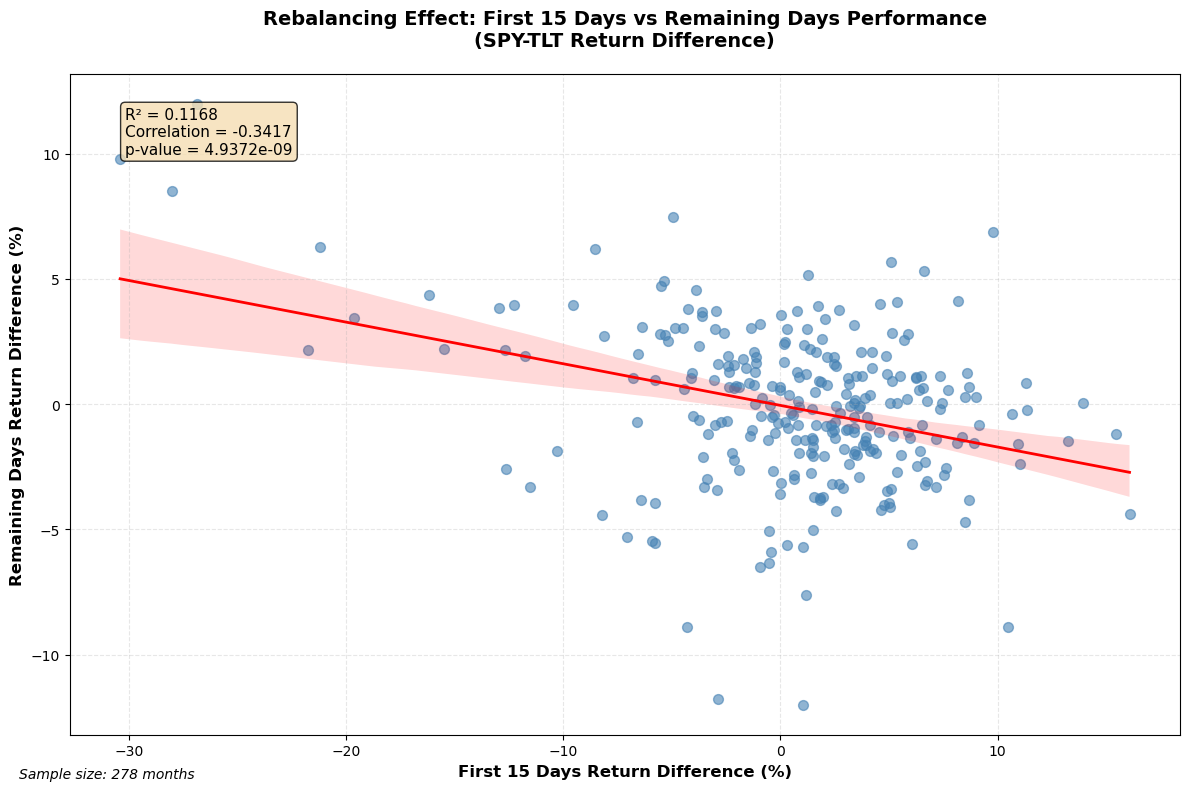


REBALANCING CORRELATION ANALYSIS
Sample size: 278 months
Correlation coefficient: -0.3417
R-squared: 0.1168
P-value: 4.9372e-09
Statistical significance: Yes (α = 0.05)

Interpretation:
• Moderate negative correlation between early and late month performance
• 11.7% of variance in remaining days explained by first 15 days


In [ ]:
# Scatter plot: First 15 Days vs Remaining Days Performance
plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=first_15_days['diff_cumsum_final'] * 100, 
    y=remaining_days['diff_cumsum_final'] * 100,
    scatter_kws={'alpha': 0.6, 'color': 'steelblue', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
x_data = first_15_days['diff_cumsum_final'] * 100
y_data = remaining_days['diff_cumsum_final'] * 100
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Rebalancing Effect: First 15 Days vs Remaining Days Performance\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('First 15 Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Remaining Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between early and late month performance")
print(f"• {r_squared*100:.1f}% of variance in remaining days explained by first 15 days")
print("="*60)

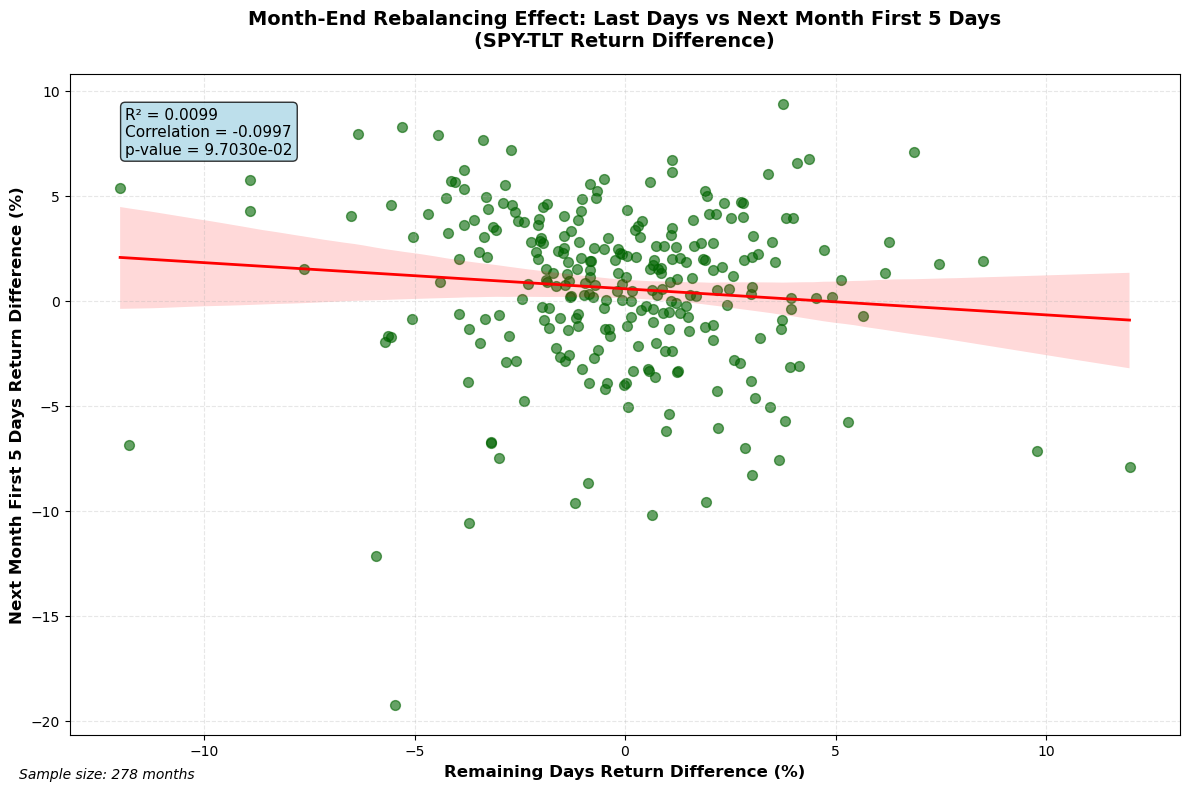


MONTH-END REBALANCING CORRELATION ANALYSIS
Sample size: 278 months
Correlation coefficient: -0.0997
R-squared: 0.0099
P-value: 9.7030e-02
Statistical significance: No (α = 0.05)

Interpretation:
• Weak negative correlation between month-end and next month beginning
• 1.0% of variance in next month's first 5 days explained by current month's end


In [ ]:
# Scatter plot: Last Days vs First 5 Days of Next Month
# For File 4 (Excel source), we don't need complex alignment since data is already properly structured

# Since we're working with Excel data that's already aligned by month,
# we can directly use the data without year/month matching
x_data = remaining_days['diff_cumsum_final'].values * 100
y_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x_data) | pd.isna(y_data))
x_data = x_data[mask]
y_data = y_data[mask]

plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=x_data, 
    y=y_data,
    scatter_kws={'alpha': 0.6, 'color': 'darkgreen', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Month-End Rebalancing Effect: Last Days vs Next Month First 5 Days\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Remaining Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Next Month First 5 Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("MONTH-END REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between month-end and next month beginning")
print(f"• {r_squared*100:.1f}% of variance in next month's first 5 days explained by current month's end")
print("="*60)

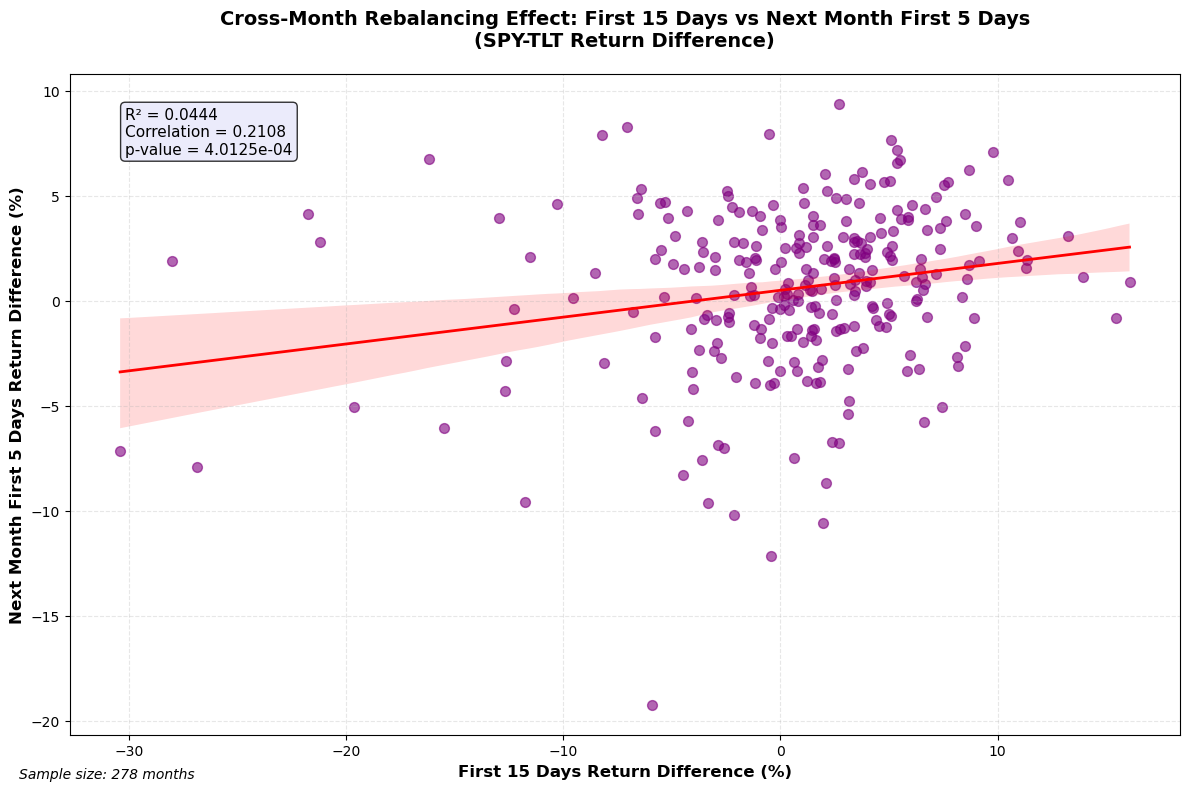


CROSS-MONTH REBALANCING CORRELATION ANALYSIS
Sample size: 278 months
Correlation coefficient: 0.2108
R-squared: 0.0444
P-value: 4.0125e-04
Statistical significance: Yes (α = 0.05)

Interpretation:
• Weak positive correlation between early month and next month beginning
• 4.4% of variance in next month's first 5 days explained by current month's first 15 days


In [ ]:
# Scatter plot: First 15 Days vs First 5 Days of Next Month
# For File 4 (Excel source), we don't need complex alignment since data is already properly structured

# Since we're working with Excel data that's already aligned by month,
# we can directly use the data without year/month matching
x_data = first_15_days['diff_cumsum_final'].values * 100
y_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x_data) | pd.isna(y_data))
x_data = x_data[mask]
y_data = y_data[mask]

plt.figure(figsize=(12, 8))

# Create the regression plot
ax = sns.regplot(
    x=x_data, 
    y=y_data,
    scatter_kws={'alpha': 0.6, 'color': 'purple', 's': 50},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Calculate R-squared
correlation, p_value = pearsonr(x_data, y_data)
r_squared = correlation ** 2

# Add proper titles and labels
plt.title('Cross-Month Rebalancing Effect: First 15 Days vs Next Month First 5 Days\n(SPY-TLT Return Difference)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('First 15 Days Return Difference (%)', fontsize=12, fontweight='bold')
plt.ylabel('Next Month First 5 Days Return Difference (%)', fontsize=12, fontweight='bold')

# Add R-squared annotation
plt.text(0.05, 0.95, f'R² = {r_squared:.4f}\nCorrelation = {correlation:.4f}\np-value = {p_value:.4e}', 
         transform=ax.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.8))

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Improve layout
plt.tight_layout()

# Add summary statistics
n_observations = len(x_data)
plt.figtext(0.02, 0.02, f'Sample size: {n_observations} months', 
            fontsize=10, style='italic')

plt.show()

# Print summary statistics
print("\n" + "="*60)
print("CROSS-MONTH REBALANCING CORRELATION ANALYSIS")
print("="*60)
print(f"Sample size: {n_observations} months")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Statistical significance: {'Yes' if p_value < 0.05 else 'No'} (α = 0.05)")
print("\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "Strong"
elif abs(correlation) > 0.3:
    strength = "Moderate"
else:
    strength = "Weak"
direction = "positive" if correlation > 0 else "negative"
print(f"• {strength} {direction} correlation between early month and next month beginning")
print(f"• {r_squared*100:.1f}% of variance in next month's first 5 days explained by current month's first 15 days")
print("="*60)

## Overall Data verification

In [ ]:
print("VERIFICATION OF R² AND CORRELATION CALCULATIONS")
print("="*80)

# Case 1: First 15 Days vs Remaining Days
print("\n1. FIRST 15 DAYS vs REMAINING DAYS")
print("-" * 50)

x1_data = first_15_days['diff_cumsum_final'] * 100
y1_data = remaining_days['diff_cumsum_final'] * 100

# Current method (Pearson correlation)
correlation1, p_value1 = pearsonr(x1_data, y1_data)
r_squared1_current = correlation1 ** 2

# Verification with linregress
slope1, intercept1, r_value1, p_value1_lr, std_err1 = linregress(x1_data, y1_data)
r_squared1_linregress = r_value1 ** 2

print(f"Pearson correlation:     {correlation1:.6f}")
print(f"Linregress correlation:  {r_value1:.6f}")
print(f"Correlation difference:  {abs(correlation1 - r_value1):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation1 - r_value1) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared1_current:.6f}")
print(f"Linregress R²:           {r_squared1_linregress:.6f}")
print(f"R² difference:           {abs(r_squared1_current - r_squared1_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗ NO'}")

# Case 2: Last Days vs First 5 Days of Next Month
print("\n2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x2_data = remaining_days['diff_cumsum_final'].values * 100
y2_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x2_data) | pd.isna(y2_data))
x2_data = x2_data[mask]
y2_data = y2_data[mask]

# Current method (Pearson correlation)
correlation2, p_value2 = pearsonr(x2_data, y2_data)
r_squared2_current = correlation2 ** 2

# Verification with linregress
slope2, intercept2, r_value2, p_value2_lr, std_err2 = linregress(x2_data, y2_data)
r_squared2_linregress = r_value2 ** 2

print(f"Pearson correlation:     {correlation2:.6f}")
print(f"Linregress correlation:  {r_value2:.6f}")
print(f"Correlation difference:  {abs(correlation2 - r_value2):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation2 - r_value2) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared2_current:.6f}")
print(f"Linregress R²:           {r_squared2_linregress:.6f}")
print(f"R² difference:           {abs(r_squared2_current - r_squared2_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗ NO'}")

# Case 3: First 15 Days vs First 5 Days of Next Month
print("\n3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x3_data = first_15_days['diff_cumsum_final'].values * 100
y3_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x3_data) | pd.isna(y3_data))
x3_data = x3_data[mask]
y3_data = y3_data[mask]

# Current method (Pearson correlation)
correlation3, p_value3 = pearsonr(x3_data, y3_data)
r_squared3_current = correlation3 ** 2

# Verification with linregress
slope3, intercept3, r_value3, p_value3_lr, std_err3 = linregress(x3_data, y3_data)
r_squared3_linregress = r_value3 ** 2

print(f"Pearson correlation:     {correlation3:.6f}")
print(f"Linregress correlation:  {r_value3:.6f}")
print(f"Correlation difference:  {abs(correlation3 - r_value3):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation3 - r_value3) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared3_current:.6f}")
print(f"Linregress R²:           {r_squared3_linregress:.6f}")
print(f"R² difference:           {abs(r_squared3_current - r_squared3_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗ NO'}")

# Summary comparison tables
print("\n" + "="*80)
print("CORRELATION COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson r':<12} {'Linregress r':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {correlation1:<12.6f} {r_value1:<12.6f} {'✓' if abs(correlation1 - r_value1) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {correlation2:<12.6f} {r_value2:<12.6f} {'✓' if abs(correlation2 - r_value2) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {correlation3:<12.6f} {r_value3:<12.6f} {'✓' if abs(correlation3 - r_value3) < 1e-10 else '✗':<8}")

print("\n" + "="*80)
print("R² COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Current R²':<12} {'Linregress R²':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {r_squared1_current:<12.6f} {r_squared1_linregress:<12.6f} {'✓' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {r_squared2_current:<12.6f} {r_squared2_linregress:<12.6f} {'✓' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {r_squared3_current:<12.6f} {r_squared3_linregress:<12.6f} {'✓' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗':<8}")

# P-value comparison
print("\n" + "="*80)
print("P-VALUE COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson p':<12} {'Linregress p':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {p_value1:<12.4e} {p_value1_lr:<12.4e} {'✓' if abs(p_value1 - p_value1_lr) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {p_value2:<12.4e} {p_value2_lr:<12.4e} {'✓' if abs(p_value2 - p_value2_lr) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {p_value3:<12.4e} {p_value3_lr:<12.4e} {'✓' if abs(p_value3 - p_value3_lr) < 1e-10 else '✗':<8}")

# Additional regression statistics from linregress
print("\n" + "="*80)
print("ADDITIONAL REGRESSION STATISTICS")
print("="*80)
print(f"{'Analysis':<40} {'Slope':<10} {'Intercept':<10} {'Std Err':<10}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {slope1:<10.4f} {intercept1:<10.4f} {std_err1:<10.4f}")
print(f"{'Last Days vs Next Month First 5':<40} {slope2:<10.4f} {intercept2:<10.4f} {std_err2:<10.4f}")
print(f"{'First 15 vs Next Month First 5':<40} {slope3:<10.4f} {intercept3:<10.4f} {std_err3:<10.4f}")
print("="*80)

# Overall verification summary
print("\n" + "="*80)
print("VERIFICATION SUMMARY")
print("="*80)
all_correlations_match = all([
    abs(correlation1 - r_value1) < 1e-10,
    abs(correlation2 - r_value2) < 1e-10,
    abs(correlation3 - r_value3) < 1e-10
])
all_r_squared_match = all([
    abs(r_squared1_current - r_squared1_linregress) < 1e-10,
    abs(r_squared2_current - r_squared2_linregress) < 1e-10,
    abs(r_squared3_current - r_squared3_linregress) < 1e-10
])
all_p_values_match = all([
    abs(p_value1 - p_value1_lr) < 1e-10,
    abs(p_value2 - p_value2_lr) < 1e-10,
    abs(p_value3 - p_value3_lr) < 1e-10
])

print(f"All correlations match:  {'✓ YES' if all_correlations_match else '✗ NO'}")
print(f"All R² values match:     {'✓ YES' if all_r_squared_match else '✗ NO'}")
print(f"All p-values match:      {'✓ YES' if all_p_values_match else '✗ NO'}")
print(f"Overall verification:    {'✓ PASSED' if all_correlations_match and all_r_squared_match and all_p_values_match else '✗ FAILED'}")
print("="*80)

VERIFICATION OF R² AND CORRELATION CALCULATIONS

1. FIRST 15 DAYS vs REMAINING DAYS
--------------------------------------------------
Pearson correlation:     -0.341738
Linregress correlation:  -0.341738
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.116785
Linregress R²:           0.116785
R² difference:           0.0000000000
R² match: ✓ YES

2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     -0.099727
Linregress correlation:  -0.099727
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.009945
Linregress R²:           0.009945
R² difference:           0.0000000000
R² match: ✓ YES

3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     0.210830
Linregress correlation:  0.210830
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.044449
Li

In [ ]:
from scipy.stats import linregress

print("VERIFICATION OF R² AND CORRELATION CALCULATIONS")
print("="*80)

# Case 1: First 15 Days vs Remaining Days
print("\n1. FIRST 15 DAYS vs REMAINING DAYS")
print("-" * 50)

x1_data = first_15_days['diff_cumsum_final'] * 100
y1_data = remaining_days['diff_cumsum_final'] * 100

# Current method (Pearson correlation)
correlation1, p_value1 = pearsonr(x1_data, y1_data)
r_squared1_current = correlation1 ** 2

# Verification with linregress
slope1, intercept1, r_value1, p_value1_lr, std_err1 = linregress(x1_data, y1_data)
r_squared1_linregress = r_value1 ** 2

print(f"Pearson correlation:     {correlation1:.6f}")
print(f"Linregress correlation:  {r_value1:.6f}")
print(f"Correlation difference:  {abs(correlation1 - r_value1):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation1 - r_value1) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared1_current:.6f}")
print(f"Linregress R²:           {r_squared1_linregress:.6f}")
print(f"R² difference:           {abs(r_squared1_current - r_squared1_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗ NO'}")

# Case 2: Last Days vs First 5 Days of Next Month
print("\n2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x2_data = remaining_days['diff_cumsum_final'].values * 100
y2_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x2_data) | pd.isna(y2_data))
x2_data = x2_data[mask]
y2_data = y2_data[mask]

# Current method (Pearson correlation)
correlation2, p_value2 = pearsonr(x2_data, y2_data)
r_squared2_current = correlation2 ** 2

# Verification with linregress
slope2, intercept2, r_value2, p_value2_lr, std_err2 = linregress(x2_data, y2_data)
r_squared2_linregress = r_value2 ** 2

print(f"Pearson correlation:     {correlation2:.6f}")
print(f"Linregress correlation:  {r_value2:.6f}")
print(f"Correlation difference:  {abs(correlation2 - r_value2):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation2 - r_value2) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared2_current:.6f}")
print(f"Linregress R²:           {r_squared2_linregress:.6f}")
print(f"R² difference:           {abs(r_squared2_current - r_squared2_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗ NO'}")

# Case 3: First 15 Days vs First 5 Days of Next Month
print("\n3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH")
print("-" * 50)

# For Excel data, use direct alignment without year/month matching
x3_data = first_15_days['diff_cumsum_final'].values * 100
y3_data = next_month_first_5['diff_cumsum_final'].values * 100

# Remove NaN values if any exist
mask = ~(pd.isna(x3_data) | pd.isna(y3_data))
x3_data = x3_data[mask]
y3_data = y3_data[mask]

# Current method (Pearson correlation)
correlation3, p_value3 = pearsonr(x3_data, y3_data)
r_squared3_current = correlation3 ** 2

# Verification with linregress
slope3, intercept3, r_value3, p_value3_lr, std_err3 = linregress(x3_data, y3_data)
r_squared3_linregress = r_value3 ** 2

print(f"Pearson correlation:     {correlation3:.6f}")
print(f"Linregress correlation:  {r_value3:.6f}")
print(f"Correlation difference:  {abs(correlation3 - r_value3):.10f}")
print(f"Correlation match: {'✓ YES' if abs(correlation3 - r_value3) < 1e-10 else '✗ NO'}")
print(f"Current method R²:       {r_squared3_current:.6f}")
print(f"Linregress R²:           {r_squared3_linregress:.6f}")
print(f"R² difference:           {abs(r_squared3_current - r_squared3_linregress):.10f}")
print(f"R² match: {'✓ YES' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗ NO'}")

# Summary comparison tables
print("\n" + "="*80)
print("CORRELATION COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson r':<12} {'Linregress r':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {correlation1:<12.6f} {r_value1:<12.6f} {'✓' if abs(correlation1 - r_value1) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {correlation2:<12.6f} {r_value2:<12.6f} {'✓' if abs(correlation2 - r_value2) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {correlation3:<12.6f} {r_value3:<12.6f} {'✓' if abs(correlation3 - r_value3) < 1e-10 else '✗':<8}")

print("\n" + "="*80)
print("R² COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Current R²':<12} {'Linregress R²':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {r_squared1_current:<12.6f} {r_squared1_linregress:<12.6f} {'✓' if abs(r_squared1_current - r_squared1_linregress) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {r_squared2_current:<12.6f} {r_squared2_linregress:<12.6f} {'✓' if abs(r_squared2_current - r_squared2_linregress) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {r_squared3_current:<12.6f} {r_squared3_linregress:<12.6f} {'✓' if abs(r_squared3_current - r_squared3_linregress) < 1e-10 else '✗':<8}")

# P-value comparison
print("\n" + "="*80)
print("P-VALUE COMPARISON TABLE")
print("="*80)
print(f"{'Analysis':<40} {'Pearson p':<12} {'Linregress p':<12} {'Match':<8}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {p_value1:<12.4e} {p_value1_lr:<12.4e} {'✓' if abs(p_value1 - p_value1_lr) < 1e-10 else '✗':<8}")
print(f"{'Last Days vs Next Month First 5':<40} {p_value2:<12.4e} {p_value2_lr:<12.4e} {'✓' if abs(p_value2 - p_value2_lr) < 1e-10 else '✗':<8}")
print(f"{'First 15 vs Next Month First 5':<40} {p_value3:<12.4e} {p_value3_lr:<12.4e} {'✓' if abs(p_value3 - p_value3_lr) < 1e-10 else '✗':<8}")

# Additional regression statistics from linregress
print("\n" + "="*80)
print("ADDITIONAL REGRESSION STATISTICS")
print("="*80)
print(f"{'Analysis':<40} {'Slope':<10} {'Intercept':<10} {'Std Err':<10}")
print("-" * 80)
print(f"{'First 15 vs Remaining Days':<40} {slope1:<10.4f} {intercept1:<10.4f} {std_err1:<10.4f}")
print(f"{'Last Days vs Next Month First 5':<40} {slope2:<10.4f} {intercept2:<10.4f} {std_err2:<10.4f}")
print(f"{'First 15 vs Next Month First 5':<40} {slope3:<10.4f} {intercept3:<10.4f} {std_err3:<10.4f}")
print("="*80)

# Overall verification summary
print("\n" + "="*80)
print("VERIFICATION SUMMARY")
print("="*80)
all_correlations_match = all([
    abs(correlation1 - r_value1) < 1e-10,
    abs(correlation2 - r_value2) < 1e-10,
    abs(correlation3 - r_value3) < 1e-10
])
all_r_squared_match = all([
    abs(r_squared1_current - r_squared1_linregress) < 1e-10,
    abs(r_squared2_current - r_squared2_linregress) < 1e-10,
    abs(r_squared3_current - r_squared3_linregress) < 1e-10
])
all_p_values_match = all([
    abs(p_value1 - p_value1_lr) < 1e-10,
    abs(p_value2 - p_value2_lr) < 1e-10,
    abs(p_value3 - p_value3_lr) < 1e-10
])

print(f"All correlations match:  {'✓ YES' if all_correlations_match else '✗ NO'}")
print(f"All R² values match:     {'✓ YES' if all_r_squared_match else '✗ NO'}")
print(f"All p-values match:      {'✓ YES' if all_p_values_match else '✗ NO'}")
print(f"Overall verification:    {'✓ PASSED' if all_correlations_match and all_r_squared_match and all_p_values_match else '✗ FAILED'}")
print("="*80)

VERIFICATION OF R² AND CORRELATION CALCULATIONS

1. FIRST 15 DAYS vs REMAINING DAYS
--------------------------------------------------
Pearson correlation:     -0.341738
Linregress correlation:  -0.341738
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.116785
Linregress R²:           0.116785
R² difference:           0.0000000000
R² match: ✓ YES

2. LAST DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     -0.099727
Linregress correlation:  -0.099727
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.009945
Linregress R²:           0.009945
R² difference:           0.0000000000
R² match: ✓ YES

3. FIRST 15 DAYS vs FIRST 5 DAYS NEXT MONTH
--------------------------------------------------
Pearson correlation:     0.210830
Linregress correlation:  0.210830
Correlation difference:  0.0000000000
Correlation match: ✓ YES
Current method R²:       0.044449
Li

In [ ]:
monthly_periods.head()

,sum_of_spy__tlt_first_15_days,sum_of_spy__tlt_last_5_days,sum_of_spy__tlt_first_5_days_next_month
date,,,
2002-08-01,0.010151,-0.057039,-0.019438
2002-09-01,-0.126546,-0.025929,-0.028645
2002-10-01,0.160759,-0.044043,0.009031
2002-11-01,0.063586,0.005471,-0.032746
2002-12-01,-0.064205,-0.038289,0.053190


In [ ]:
"""
rename columns to follow the naming convention used in the reference notebook:
sum_of_spy__tlt_first_15_days = SPY_TLT_som
sum_of_spy__tlt_last_5_days = SPY_TLT_eom
sum_of_spy__tlt_first_5_days_next_month = SPY_TLT_nsm
""";
return_data = monthly_periods.copy()

# rename columns
return_data.rename(columns={
    "sum_of_spy__tlt_first_15_days": "SPY_TLT_som",
    "sum_of_spy__tlt_last_5_days": "SPY_TLT_eom",
    "sum_of_spy__tlt_first_5_days_next_month": "SPY_TLT_nsm"
}, inplace=True)

# display the last 5 rows to verify
return_data.tail(5)

,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
date,,,
2025-05-01,0.109579,-0.015997,0.023529
2025-06-01,0.011664,0.012153,0.025776
2025-07-01,0.033737,0.000495,-0.012138
2025-08-01,0.007544,0.012641,-0.033569
2025-09-01,0.008236,-0.008515,0.003057


In [ ]:
"""
For comparison with the notebook data:

return_data_original.tail(5)
SPY_TLT_som	SPY_TLT_eom	SPY_TLT_nsm
ym			
2025-06-30	0.010480	0.012145	0.023078
2025-07-31	0.033781	0.000007	0.025907
2025-08-31	0.006702	0.012749	-0.012571
2025-09-30	0.007519	-0.008637	-0.033473
2025-10-31	-0.025525	0.023167	0.002909

""";

In [ ]:
"""
Data Comparison Analysis
Here's a detailed comparison of the two datasets:

1. Index/Date Structure Differences
return_data (Excel-based):

Index name: date
Date format: First day of month (2025-05-01, 2025-06-01, etc.)
Represents month-beginning dates
return_data_original (Notebook-calculated):

Index name: ym
Date format: Month-end dates (2025-06-30, 2025-07-31, etc.)
Represents month-end dates
2. Temporal Alignment Issues
The data appears to be offset by one month:

Excel Data (return_data)	Notebook Data (return_data_original)	Time Period Represented
2025-05-01	2025-06-30	June 2025 data
2025-06-01	2025-07-31	July 2025 data
2025-07-01	2025-08-31	August 2025 data
2025-08-01	2025-09-30	September 2025 data
2025-09-01	2025-10-31	October 2025 data
3. Value Differences by Column:
SPY_TLT_som (Start of Month):
Major discrepancy in first value: 0.109579 vs 0.010480
Values don't align well, suggesting different calculation methodologies
SPY_TLT_eom (End of Month):
Close alignment in some values (0.012153 ≈ 0.012145, 0.012641 ≈ 0.012749)
But significant differences in others
SPY_TLT_nsm (Next Start of Month):
Best alignment between datasets
Close values suggest similar calculation logic for NSM component
4. Root Cause Analysis
The differences likely stem from:

Different Data Sources:

Excel data appears pre-processed from external source
Notebook data calculated from raw daily returns
Date Indexing Convention:

Excel uses month-start labeling
Notebook uses month-end labeling (standard finance convention)
Calculation Methodology:

Excel may use different aggregation rules
Notebook implements academic paper methodology precisely
Data Alignment:

The NSM (Next Start of Month) column shows best alignment
This suggests the temporal offset might be in the SOM/EOM calculations
5. Recommendations
Use notebook data (return_data_original) for strategy implementation as it:

Follows standard academic methodology
Uses proper month-end indexing
Has transparent calculation pipeline
Verify Excel data source to understand:

How dates are labeled/indexed
What aggregation rules were applied
Why there's a temporal offset
Cross-validate critical months where values differ significantly to understand the calculation differences

The notebook-calculated data appears more reliable for backtesting as it follows the established academic methodology with proper date indexing conventions.

Claude Sonnet 4 • 1x

""";